# STEP 1. Patient Segmentation 

- step 1a. define the patients( who they're aka feature)
- step 1b. define the patients sessions

In [3]:
# step 1a --- defining patients / sessions 

import pandas as pd

patients = pd.read_csv("C:/Users/Muham/Downloads/AMDARI/medoptix-ai-internship/medoptix_data/raw/patients.csv")
sessions = pd.read_csv("C:/Users/Muham/Downloads/AMDARI/medoptix-ai-internship/medoptix_data/raw/sessions.csv")
dropout_flag = pd.read_csv("C:/Users/Muham/Downloads/AMDARI/medoptix-ai-internship/medoptix_data/raw/dropout_flags.csv")

In [4]:
# step 1b --- Define the sessions the patients had in relations to the therapy (EXTRA FEATURE ENGINEERING)-- Dynamic dataset

sess_agg = (
    sessions
    .sort_values(['patient_id', 'date'])    # putting every patient session in calender mode
    .assign(pain_delta=lambda d: (d.groupby("patient_id")["pain_level"].diff() # create a new column help save change in new pain level
    ))
    .groupby("patient_id") #grouped by patient ID -- collect all the rows belonging to each patient
    .agg (
        n_sessions = ("session_id", "count"),           # defining some extra insights into the session data
        avg_session_duration = ("duration", "mean"),
        first_week = ("week", "min"),
        last_week = ("week", "max"),
        mean_pain = ("pain_level", "mean"),
        mean_pain_delta = ("pain_delta", "mean"),
        home_adherence_mean = ("home_adherence_pc", "mean"),
        satisfaction_mean = ("satisfaction", "mean")
    )
)

sess_agg.head(3)

,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,
1,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000
2,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000
3,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176


In [5]:
# step 1c Define the patients (static dataset)
pat_sel = patients.set_index("patient_id")

pat_sel.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type
patient_id,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public
3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44.286283,GP,True,5,Public


In [6]:
# step 1d -- join static dataset + dynamice (Behvaioral features)

X_raw = pat_sel.join(sess_agg, how="left")
X_raw.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000
3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44.286283,GP,True,5,Public,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176


In [7]:
# step 1e Label engineering & encoding 

# patient static attributes ----- define what describes a patient
pat_sel = patients[
    [
        "patient_id",
        "age",
        "gender",
        "bmi",
        "smoker",
        "chronic_cond",
        "injury_type",
        "referral_source",
        "insurance_type"
    ]
].set_index("patient_id")


# label engineering (attach the drop out flags to the patient)
# use labels as your source of truth which we'd later use in prediction (who dropped out or not)
label = dropout_flag.set_index("patient_id").dropout 

In [8]:
X_raw.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000
3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44.286283,GP,True,5,Public,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176


In [9]:
#step 1f  Data Pipeline --- compress all your data preprocessing step into one pipeline 

# step 1f-i -- Define your numeric columns and Categorical columns (non-numeric)

num_col = [                                  
    "age", "bmi",
    "n_sessions", "avg_session_duration",
    "mean_pain", "mean_pain_delta",
    "home_adherence_mean", "satisfaction_mean"
]

cat_col = [
    "gender", "smoker",
    "chronic_cond", "injury_type", "referral_source", "insurance_type", "consent"
]

X_raw[cat_col].astype("string")  # casting categorical data

,gender,smoker,chronic_cond,injury_type,referral_source,insurance_type,consent
patient_id,,,,,,,
1,Male,False,<NA>,Knee,Insurance,Public,True
2,Female,True,<NA>,Shoulder,Insurance,Public,False
3,Male,False,<NA>,Hip,GP,Public,True
4,Female,False,<NA>,Back,GP,Private-Premium,True
5,Female,False,<NA>,Shoulder,Insurance,Private-Basic,True
...,...,...,...,...,...,...,...
4996,Female,True,Diabetes,Back,Self-Referral,Private-Basic,True
4997,Female,False,<NA>,Shoulder,Self-Referral,Private-Basic,True
4998,Female,False,<NA>,Back,GP,Public,True


In [10]:
# step 1g - Preprocessing with the pipeline 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer


numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scalar", RobustScaler())
    ]
)



categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onhot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)


In [11]:
#### Column Transformer 

preproc = ColumnTransformer(
    transformers= [
        ("num", numeric_pipe, num_col),
        ("cat", categorical_pipe, cat_col)
    ]
)

print(type(preproc))

<class 'sklearn.compose._column_transformer.ColumnTransformer'>


### step h:  clustering
 - define K-means
 
 - ELbow 
 - silhouette
 - choose K & get your cluster
 - DBSCAN 
 - PCA
 - Answer Dropout question ("fast_imporver", "steady progresser", "frustrated_droppers")


##### define our k 

- group the patients into meaningful persona

    - step h-i ---- loop through a range of k (assumptions)
    - step h-ii ---- plotting the elbow 
    - step h-iii - plotting the silhoutee
    - step h-iv ---- decision making & choosing of k





In [17]:
# step h-1 : define a function (Search for K)
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import  matplotlib.pyplot as plt

def k_search(X, k_range=range(2,11)):
    wcss, sils = [], []
    
    for k in k_range:                    # loop through the range of k
        km = KMeans(
            n_clusters= k,
            init = "k-means++",          # First centroid start start far apart 
            n_init= "auto",
            random_state= 42,
            algorithm = "lloyd",
        )
        preds = km.fit_predict(X)           # runs the algorithm & returns a cluster id for each patient
        wcss.append(km.inertia_)            # Elbows tension inside clusters  AKA rubber band effect 
        sils.append(silhouette_score(X, preds))  # Silhouteee hows seperate & compact each point is 
    return wcss, sils

In [ ]:
# modeling the data
X_raw.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000
3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44.286283,GP,True,5,Public,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176


In [ ]:
# model our data
X_pre = preproc.fit_transform(X_raw)

Text(0, 0.5, 'WCSS')

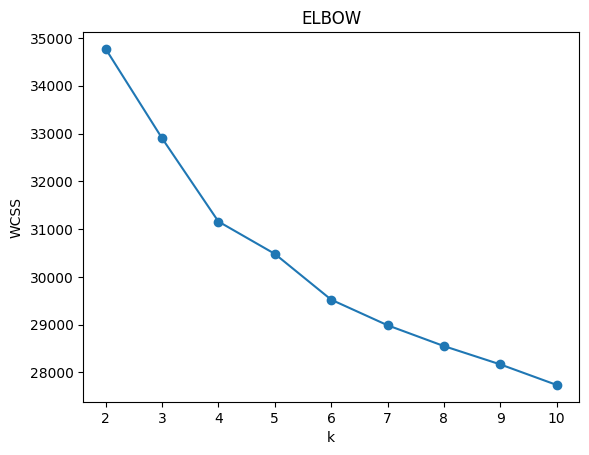

In [ ]:
# step h-ii : Plot our elbow and silhouteee
wcss , sils = k_search(X_pre)

plt.figure; plt.plot(range(2,11), wcss, 'o-')
plt.title("ELBOW")
plt.xlabel("k"); plt.ylabel("WCSS")

Text(0, 0.5, 'silhoutee score')

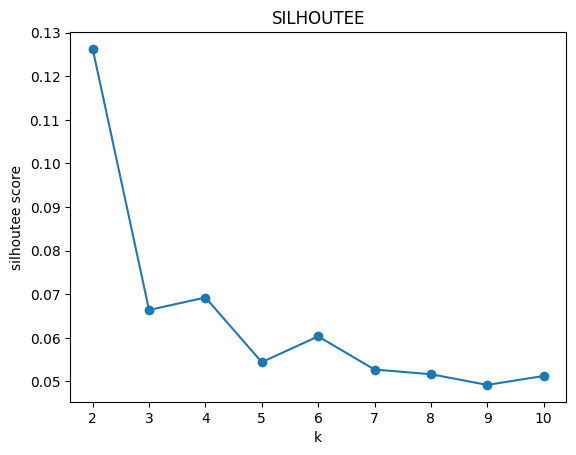

In [25]:
# step h-iii plotting the silhoutee

plt.figure; plt.plot(range(2,11),sils, 'o-')
plt.title("SILHOUTEE")
plt.xlabel("k"); plt.ylabel("silhoutee score")

###### Rule of thumb : pick the smallet k past the elbow and hwos silhoutee closer to the KPI (e.g business >=0.6)

In [28]:
# step h-iv Choose our k = 4

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


k_OPT = 4 
k_means = KMeans(
    n_clusters=k_OPT, n_init="auto",
    random_state=42, algorithm="lloyd"
)
clusters = k_means.fit_predict(X_pre)


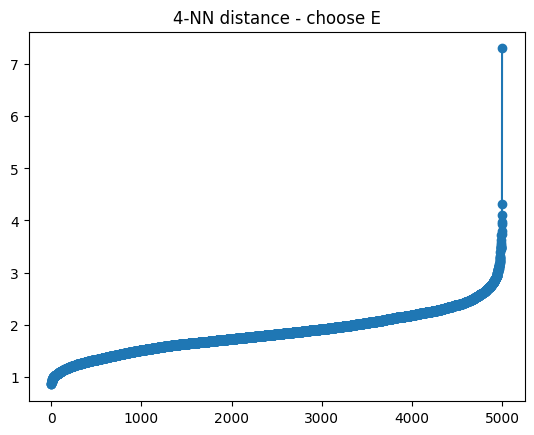

In [30]:
# DBSCAN ---- catch any extra outliers 
knn = NearestNeighbors(n_neighbors=4).fit(X_pre)
dists = np.sort(knn.kneighbors(X_pre)[0][:,-1])

plt.figure(); plt.plot(dists, 'o-'); plt.title("4-NN distance - choose E"); plt.show()

In [ ]:
db        = DBSCAN(eps=2.3, min_samples=4).fit(X_pre)
db_labels = db.labels_
sil_db    = silhouette_score(X_pre[db_labels != -1],
                             db_labels[db_labels != -1])
print(f"DBSCAN valid-cluster silhouette: {sil_db:.3f}")

# ---------------- PCA / t-SNE visual -----------------------
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE

pca2  = PCA(n_components=2, random_state=42).fit_transform(X_pre)
tsne2 = TSNE(n_components=2, perplexity=40,
             init="pca", random_state=42).fit_transform(X_pre)

def scatter_2d(mat, labels, title):
    plt.figure(figsize=(5, 4))
    plt.scatter(mat[:, 0], mat[:, 1], c=labels, alpha=0.6, s=10)
    plt.title(title); plt.axis("off")

scatter_2d(pca2,  clusters, "PCA – coloured by K-Means cluster")
scatter_2d(tsne2, clusters, "t-SNE – coloured by K-Means cluster")

DBSCAN valid-cluster silhouette: 0.158
